## Import delle librerie utilizzate

In [8]:
from multiprocessing import get_all_start_methods
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import  RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier

from joblib import dump, load
import os

## Training:

      Bankrupt?   ROA(C) before interest and depreciation before interest  \
0             1                                           0.370594          
1             1                                           0.464291          
2             1                                           0.426071          
3             1                                           0.399844          
4             1                                           0.465022          
...         ...                                                ...          
6814          0                                           0.493687          
6815          0                                           0.475162          
6816          0                                           0.472725          
6817          0                                           0.506264          
6818          0                                           0.493053          

       ROA(A) before interest and % after tax  \
0                         

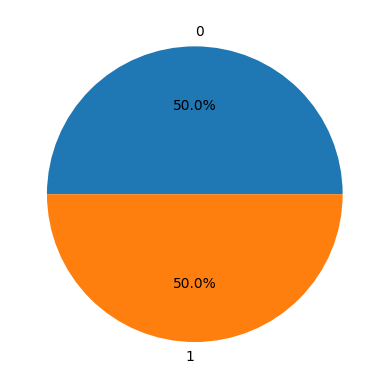

In [9]:
def Load_dataset(file_name, test_perc, class_label, sampling = None, plot=False):
    """
    Load the dataset from a .csv file

    Parameters
    ----------
    :param str file_name: csv file that hold the complete dataset.
    :param float training_perc: (0, 1) Percentage of samples used for training
    :param str labels: Class names used as target for ML algorithms
    :param str sampling: default = None
        "oversampling" - Enable oversampling for compensate imbalanced classes
        "undersampleing" - Enable undersampleing for compensate imbalanced classes
        "None" - Classes are loaded "as it is"
    :param bool plot: Enable classes distribution plotting

    Returns
    ----------
    splitting: list, length=2 * len(arrays)
        List containing train-test split of inputs.
    """

    #assert(os.path.isfile(file_name) == True), f"Unvalid dataset file {file_name}"

    raw_data = pd.read_csv(file_name)

    print(raw_data)

    data = raw_data.drop(columns=class_label)
    target = raw_data[class_label]

    x_train, x_test, y_train, y_test = train_test_split(
        data,
        target,
        test_size=test_perc,
        random_state=42
    )

    # Check for sampling condition
    if(sampling == "resample"):
        re_samp = RandomOverSampler(
            sampling_strategy = 'minority',
            random_state=42
        )
        x_over, y_over = re_samp.fit_resample(x_train, y_train)

        re_samp = RandomUnderSampler(
            sampling_strategy = 'majority',
            random_state=42
        )
        x_under, y_under = re_samp.fit_resample(x_train, y_train)

        x_train = pd.concat([x_over, x_under], ignore_index=True)
        y_train = pd.concat([y_over, y_under], ignore_index=True)

    # Plot the distribution of class values
    if (plot == True):
        cnt = Counter(y_train)
        y_values = cnt.values()
        x_values = cnt.keys()

        fig, ax = plt.subplots()
        ax.pie(y_values, labels=x_values, autopct='%1.1f%%')

        plt.show()

    return (x_train, x_test, y_train, y_test)

x_train, x_test, y_train, y_test = Load_dataset(
    "Company_Bankruptcy_Prediction.csv",
    .25,
    "Bankrupt?",
    sampling = "resample",
    plot = True
)

## Gestione delle metriche

In [14]:
class Metric:
    name = ""
    classes = None
    accuracy = None
    missclassification = None
    precision = None
    recall_score = None
    f1 = None
    conf_matrix = []

    fpr = []
    tpr = []
    auc = []

    def __init__(self, name):
        self.name = name
        pass

    def Get_metrics(self):
        return {
            "accuracy": self.accuracy,
            "missclassification": self.missclassification,
            "precision": self.precision,
            "recall_score": self.recall_score,
            "f1": self.f1,
        }

    def Print(self):
        print(self.name + ":")
        df = pd.DataFrame([self.Get_metrics()])
        print(df)
        print("-----------------")
        print("\n")

    def Plot_confusion_matrix(self):
        if(len(self.conf_matrix) == 0):
            return

        heatmap = sns.heatmap(self.conf_matrix, annot=True, cmap="viridis")
        heatmap.set_title(f"{self.name} Confusion Matrix")
        plt.show()

    def Plot_roc_curve(self):
        if(len(self.fpr) == 0 or len(self.tpr) == 0):
            return

        plt.plot(self.fpr, self.tpr, label=f"AUC={self.auc:.4f}")
        plt.plot([0, 1], [0, 1], "k--", lw=2)
        plt.xlim([0.0, 1.05])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{self.name} ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

def Compute_metrics(classifier, predictions, x_test, y_test, metric, export = None):
    metric.classes = classifier.classes_
    metric.accuracy = accuracy_score(y_test, predictions)
    metric.missclassification = 1 - metric.accuracy
    metric.precision = precision_score(y_test, predictions, average = "weighted", zero_division=0)
    metric.recall_score = recall_score(y_test, predictions, average = "weighted", zero_division=0)
    metric.f1 = f1_score(y_test, predictions, average = "weighted", zero_division=0)
    metric.conf_matrix = confusion_matrix(y_test, predictions)

    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
    y_pred_proba = classifier.predict_proba(x_test)[::,1]
    metric.fpr, metric.tpr, _ = roc_curve(y_test, y_pred_proba)
    metric.auc = roc_auc_score(y_test, y_pred_proba)

    #if(export):
    #    Export_model(metric.name, classifier)

## Decision Tree:

In [25]:
def Use_decision_tree_classifier(
        x_train, x_test, y_train, y_test,
        metric,
        export = False):
    """
    Decision tree classifier
    """
    classifier = DecisionTreeClassifier(
        random_state = 42
    )

    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)

    Compute_metrics(classifier, predictions, x_test, y_test, metric, export)

Esegui **Decision Tree**

Decision Tree:
   accuracy  missclassification  precision  recall_score        f1
0  0.954839            0.045161   0.955953      0.954839  0.955387
-----------------




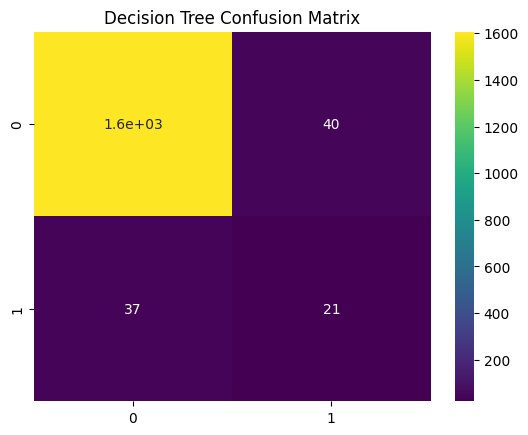

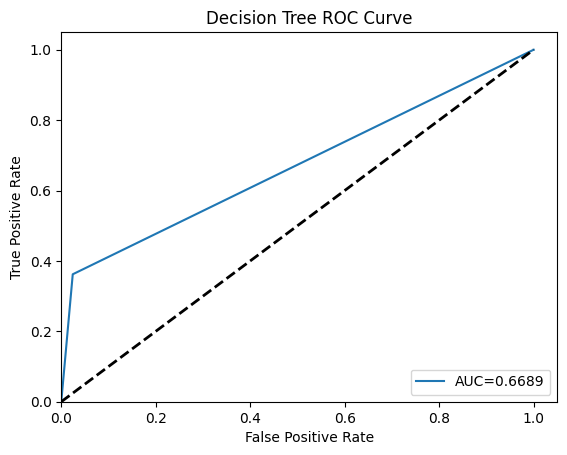

In [26]:
dt = Metric("Decision Tree")
Use_decision_tree_classifier(x_train, x_test, y_train, y_test, dt)

dt.Print()
dt.Plot_confusion_matrix()
dt.Plot_roc_curve()

## K-nearest neighbors:

In [19]:
def Use_knn_classifier(
        x_train, x_test, y_train, y_test,
        metric,
        export = False):
    """
    Nearest neighbors classifier
    """
    classifier = KNeighborsClassifier(
        n_neighbors=2
    )
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)

    Compute_metrics(classifier, predictions, x_test, y_test, metric, export)

Esegui **K-nearest neighbors**

K-NN:
   accuracy  missclassification  precision  recall_score        f1
0  0.957771            0.042229   0.953359      0.957771  0.955412
-----------------




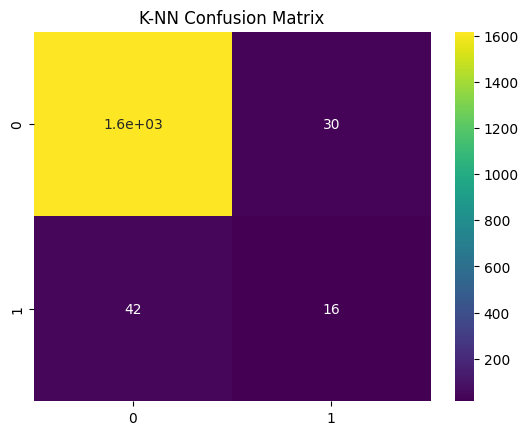

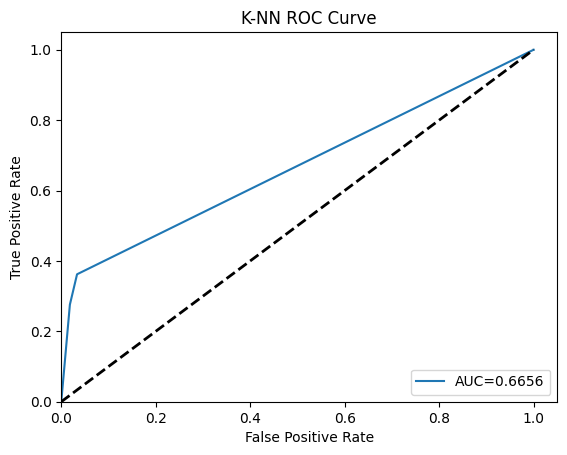

In [20]:
knn = Metric("K-NN")
Use_knn_classifier(x_train, x_test, y_train, y_test, knn)

knn.Print()
knn.Plot_confusion_matrix()
knn.Plot_roc_curve()

## Random forest:

In [21]:
def Use_rnd_forest_classifier(
        x_train, x_test, y_train, y_test,
        metric,
        export = False):
    """
    Random Forest classifier
    """
    classifier = RandomForestClassifier(
        n_estimators=100,
        random_state = 42,
    )
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)

    Compute_metrics(classifier, predictions, x_test, y_test, metric, export)

Esegui **Random Forest**

Random Forest:
   accuracy  missclassification  precision  recall_score        f1
0  0.966569            0.033431   0.958291      0.966569  0.960629
-----------------




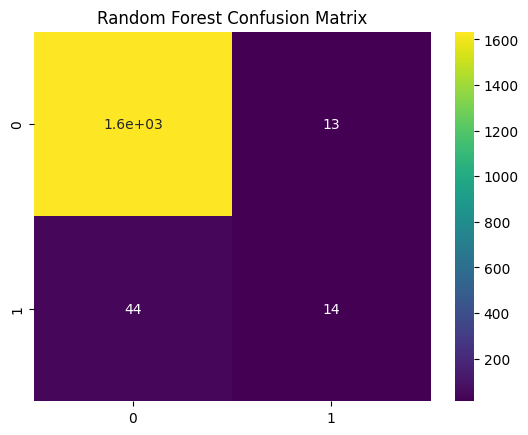

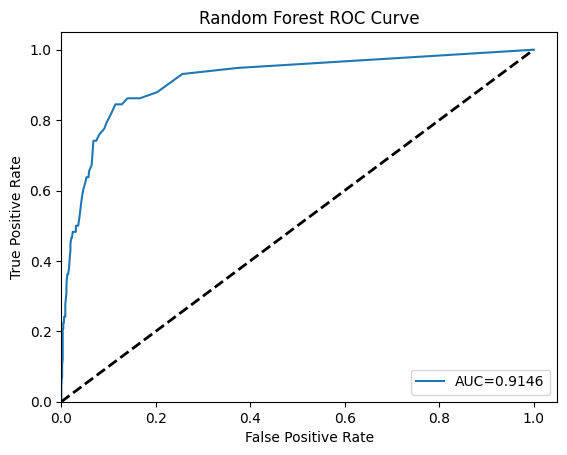

In [22]:
rnd_forest = Metric("Random Forest")
Use_rnd_forest_classifier(x_train, x_test, y_train, y_test, rnd_forest)

rnd_forest.Print()
rnd_forest.Plot_confusion_matrix()
rnd_forest.Plot_roc_curve()

## AdaBoost:

In [23]:
def Use_adaboost_classifier(
        x_train, x_test, y_train, y_test,
        metric,
        export = False):
    """
    Ensemble AdaBoost
    """

    weak_learner = RandomForestClassifier(
        n_estimators=100,
        random_state = 42,
        max_depth = 4,
    )

    classifier = AdaBoostClassifier(estimator=weak_learner)

    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)

    Compute_metrics(classifier, predictions, x_test, y_test, metric, export)

Esegui **AdaBoost**

AdaBoost:
   accuracy  missclassification  precision  recall_score        f1
0  0.965982            0.034018   0.967686      0.965982  0.966788
-----------------




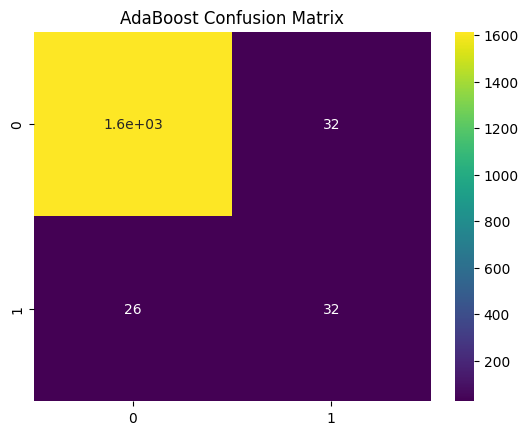

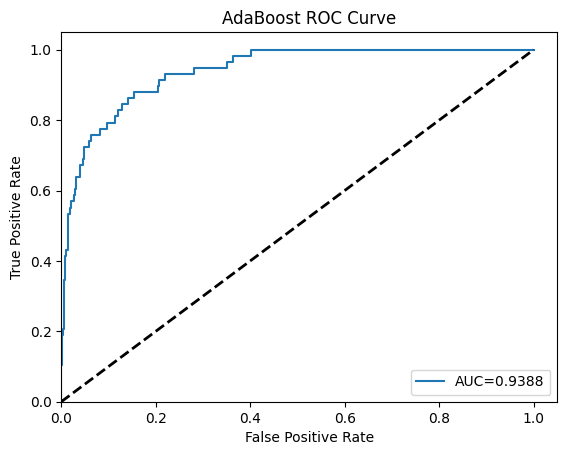

In [24]:
ada = Metric("AdaBoost")
Use_adaboost_classifier(x_train, x_test, y_train, y_test, ada)

ada.Print()
ada.Plot_confusion_matrix()
ada.Plot_roc_curve()